In [1]:
!pip install wandb -q
!pip install -r requirements.txt -q
!pip install stable-baselines3[extra] pybullet -q

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import wandb
wandb.login(key="ec10b740c0a116fa604060cad8e84f386810919d")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# import os 

# import pybullet_envs

# from stable_baselines3 import PPO
# from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.vec_env import VecNormalize

# from torchvision import transforms
# obs = torch.tensor([[0.01,3.01902573,0.02,1.69186599,0.03,2.07501123,0.01,3.01902573,0.02,1.69186599,0.03,2.07501123],[8,3.01902573,10,1.69186599,0.03,2.07501123,0.01,3.01902573,0.02,1.69186599,0.03,2.07501123]])
# envs.sim.x0 = obs
import numpy as np
W = np.array([[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],  # state waypoints (1,1,1) is where we are at and we want to go to (2,1,1)
          [0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]])

world = World()  # <-- we need the parenthesis!!!
envs = DroneSim(world, goal=W[-1][[1, 3, 5]])    

envs.action_space.low = [0,0,0]
envs.action_space.high = [5,5,5]
envs = ClipAction(envs)



# envs.num_envs = 1
# envs = VecNormalize(envs, norm_obs=True, norm_reward=False, clip_obs=5.)
# obs = envs.reset([1,1,1])
# print(obs)


# # from baselines. import VecEnvWrapper
# # from gym.wrappers import VecEnvWrapper
# # VecEnvWrapper
# # epsilon = 1e-15
# # nomalized_data = (data - data.mean(dim=0)) / (torch.sqrt(data.var(dim=0)+epsilon))
# # print(nomalized_data)

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/DeepRL/SR_RL/ML_SR')

import os
import time

import numpy as np
import torch
from collections import deque

from envs.droneSim import DroneSim
from envs.world import World

from arguments import get_args
from evaluation import evaluate

from a2c_ppo_acktr import algo, utils
from a2c_ppo_acktr.algo import gail
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage

In [7]:
use_wandb = True

config = {
    'lr': 0.00007,
    'num_env_steps':  500.0, #20.0, #1000.0,
    'num_steps': 32, #20,
    'num_episodes': 100
}

# # NaN Case
# config = {
#     'lr': 0.005953,
#     'num_env_steps': 1000.0, #1000.0,
#     'num_steps': 64, #20,
#     'num_episodes': 5
# }

# sweep_configuration = {
#     'method': 'random',
#     'name': 'sweep',
#     'metric': {
#         'goal': 'minimize', 
#         'name': 'return0'
# 		},
#     'parameters': {
#         'num_steps': {'values': [20, 32, 64]},
#         'lr': {'max': 0.1, 'min': 0.0001},
#         'num_env_steps': {'values': [1000]},
#         'num_episodes': {'values': [1]}
#      }
# }

if use_wandb:
  # Create your wandb run
  run = wandb.init(
      name = "a2c_episode_{}_1026".format(config['num_episodes']), ### Wandb creates random run names if you skip this field, we recommend you give useful names
      reinit=True, ### Allows reinitalizing runs when you re-run this cell
      project="DeepRL", ### Project should be created in your wandb account 
      config=config ### Wandb Config for your run
  )

  # sweep_id = wandb.sweep(sweep=sweep_configuration, project="DeepRL")

wandb: Currently logged in as: sangela. Use `wandb login --relogin` to force relogin


In [ ]:
from gym.wrappers import ClipAction

def train_sweep(config = None):
        from argparse import Namespace
        args = Namespace(algo='a2c', 
                      alpha=0.99, 
                      clip_param=0.2, 
                      cuda=True, 
                      cuda_deterministic=False, 
                      entropy_coef=0.01, 
                      env_name='SR_RL', 
                      eps=1e-05, 
                      eval_interval=None, 
                      gae_lambda=0.95, 
                      gail=False, 
                      gail_batch_size=128, 
                      gail_epoch=5, 
                      gail_experts_dir='./gail_experts', 
                      gamma=0.99, 
                      log_dir='/tmp/gym/', 
                      log_interval= 10, 
                      lr=config['lr'], 
                      max_grad_norm=0.5, 
                      no_cuda=False, 
                      num_env_steps=config['num_env_steps'], #10000000.0, 
                      num_mini_batch=32, 
                      num_processes=1, 
                      num_steps=config['num_steps'], 
                      ppo_epoch=4, 
                      recurrent_policy=False, 
                      save_dir='./trained_models/', 
                      save_interval=100, 
                      seed=12345, 
                      use_gae=True, 
                      use_linear_lr_decay=False, 
                      use_proper_time_limits=False, 
                      value_loss_coef=0.5)

        rng = np.random.default_rng(args.seed)
        torch.manual_seed(args.seed)
        torch.cuda.manual_seed_all(args.seed)

        if args.cuda and torch.cuda.is_available() and args.cuda_deterministic:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True

        log_dir = os.path.expanduser(args.log_dir)
        eval_log_dir = log_dir + "_eval"
        utils.cleanup_log_dir(log_dir)
        utils.cleanup_log_dir(eval_log_dir)

        torch.set_num_threads(1)
        device = torch.device("cuda:0" if args.cuda else "cpu")

        # Define env
        W = np.array([[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],  # state waypoints (1,1,1) is where we are at and we want to go to (2,1,1)
                  [0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]])
        
        world = World()  # <-- we need the parenthesis!!!
        # if use_wandb:
        #   world = World(use_wandb=use_wandb, wandb_instance=wandb)
        
        global envs
        envs = DroneSim(world, goal=W[-1][[1, 3, 5]])    
        
        envs.num_envs = 1
        # envs = VecNormalize(envs, norm_obs=True, norm_reward=False, clip_obs=5.)

        # # TO DO: Move to env class
        # envs.action_space.low = [0,0,0]
        # envs.action_space.high = [5,5,5]
        # envs = ClipAction(envs)
        
        actor_critic = Policy(
            envs.observation_space.shape,
            envs.action_space,)
        actor_critic.to(device)

        if args.algo == 'a2c':
            agent = algo.A2C_ACKTR(
                actor_critic,
                args.value_loss_coef,
                args.entropy_coef,
                lr=args.lr,
                eps=args.eps,
                alpha=args.alpha,
                max_grad_norm=args.max_grad_norm)

        rollouts = RolloutStorage(args.num_steps, args.num_processes,
                                  envs.observation_space.shape, envs.action_space,
                                  actor_critic.recurrent_hidden_state_size)
        done = False
        for i in range(config['num_episodes']):
            # start = 5 * rng.random((3))
            # goal = (5 * rng.random((3))).tolist()
            start = [1,1,1]
            goal = [3,3,3]
            print("start={} goal={} ".format(start,goal))
            
            obs = envs.reset(start=start)
            # envs = RescaleAction(envs, min_action=0, max_action=5)  # [0,0,0] [5,5,5]

            print("initial obs:",obs[[1,3,5]])
            print("intiial pos:",envs.sim.x0[[1,3,5]])
            envs.goal = goal
            
            obs = torch.as_tensor(obs)
            rollouts.obs[0].copy_(obs)
            rollouts.to(device)

            episode_rewards = deque(maxlen=10)

            start = time.time()
            num_updates = int(
                args.num_env_steps) // args.num_steps // args.num_processes
            
            tmp_count = 0
            for j in range(num_updates):
                
                if args.use_linear_lr_decay:
                    # decrease learning rate linearly
                    utils.update_linear_schedule(
                        agent.optimizer, j, num_updates,
                        agent.optimizer.lr if args.algo == "acktr" else args.lr)

                for step in range(args.num_steps):
                    tmp_count += 1
                    print("Local Step={} Global Step={}".format(step,tmp_count))
                    # Sample actions
                    with torch.no_grad():
                        value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                            rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                            rollouts.masks[step])
                    print("Sample Actions")
                    print("value={} action={} action_log_prob={} recurrent_hidden_states={}".format(value,action,action_log_prob,recurrent_hidden_states))

                    # Observe reward and next obs
                    obs, reward, done, infos = envs.step(action.flatten().tolist())
                    print("Observe Reward")
                    print("obs:",obs[[1,3,5]])
                    # print("x0:",envs.sim.x0[[1,3,5]])
                    # print("reward={} done={}".format(reward,done))

                    for info in infos:
                        if 'episode' in info.keys():
                            episode_rewards.append(info['episode']['r'])

                    # If done then clean the history of observations.
                    masks = torch.FloatTensor(
                        [[0.0] if done else [1.0]])
                    bad_masks = torch.FloatTensor(
                        [[0.0] if 'bad_transition' in infos.keys() else [1.0]])
                    # print("masks:", masks)
                  
                    obs = torch.as_tensor(obs)
                    reward = torch.as_tensor(reward)
                    rollouts.insert(obs, recurrent_hidden_states, action,
                                    action_log_prob, value, reward, masks, bad_masks)
                    
                    if done:
                      break

                with torch.no_grad():
                    next_value = actor_critic.get_value(
                        rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                        rollouts.masks[-1]).detach()
                
                rollouts.compute_returns(next_value, args.use_gae, args.gamma,
                                          args.gae_lambda, args.use_proper_time_limits)

                value_loss, action_loss, dist_entropy = agent.update(rollouts)

                total_num_steps = (j + 1) * args.num_processes * args.num_steps

                if use_wandb:
                  wandb.log({"value loss": value_loss,
                            "action loss": action_loss,
                            "dist entropy": dist_entropy,
                            "return0": rollouts.returns[0],
                            "updates": j,
                            "num timesteps": total_num_steps,
                            "episode": i})
                print({"value loss": value_loss,
                          "action loss": action_loss,
                          "dist entropy": dist_entropy,
                          "return0": rollouts.returns[0],
                          "updates": j,
                          "num timesteps": total_num_steps,
                          "episode": i})

                rollouts.after_update()

                if done:
                  print("Done in {} steps".format(total_num_steps))
                  break
        return envs
  
# wandb.agent(sweep_id=sweep_id, function=train_sweep,count=10)
envs = train_sweep(config)

Streaming output truncated to the last 5000 lines.
Observe Reward
obs: [1.74275039e-03 6.55184100e-16 7.77638503e-01]
Local Step=17 Global Step=370
dist.sample
Sample Actions
value=tensor([[-2.6176]], device='cuda:0') action=tensor([[0.0000, 0.0000, 1.6524]], device='cuda:0') action_log_prob=tensor([[-6.7760]], device='cuda:0') recurrent_hidden_states=tensor([[0.]], device='cuda:0')
Before do sim: [1.74275039e-03 6.55184100e-16 7.77638503e-01]
After do sim: [ 3.80877361e-06 -3.37105343e-16  1.34019469e+00]
Observe Reward
obs: [ 3.80877361e-06 -3.37105343e-16  1.34019469e+00]
Local Step=18 Global Step=371
dist.sample
Sample Actions
value=tensor([[-2.4334]], device='cuda:0') action=tensor([[0.0000, 0.0000, 1.7905]], device='cuda:0') action_log_prob=tensor([[-6.6926]], device='cuda:0') recurrent_hidden_states=tensor([[0.]], device='cuda:0')
Before do sim: [ 3.80877361e-06 -3.37105343e-16  1.34019469e+00]
After do sim: [ 8.71845160e-09 -8.60436748e-17  1.75436685e+00]
Observe Reward
obs: [

In [6]:
wandb.finish()

action loss,▁▂▃▄▅▄▄▅▆▆▅▆▇▆▇▆▆▆▆▆▆▇▇▇▆█▇▇▇▇▆▇▇▇▇▇▆▇▇▆
dist entropy,█▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
episode,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████
num timesteps,▂▁█▇▁▃▁▅▆▅▅▁▁▃▃▂▃▂▃▁▂▁▁▂▆▁▇▂▃▂▁█▇▆▇▆▅▃▂▁
return0,▃▁▃▄▄▄▄▄▅▅▄▄█▆▅▅▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
updates,▂▁█▇▁▃▁▅▆▅▅▁▁▃▃▂▃▂▃▁▂▁▁▂▆▁▇▂▃▂▁█▇▆▇▆▅▃▂▁
value loss,█▆▅▄▃▄▃▂▂▂▃▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
action loss,-54.83642
dist entropy,4.18959
episode,67
num timesteps,256


# Plot Trajectory

In [7]:
envs.sim.collect_traj

[array([ 7.46846625e-03,  2.80277054e+00,  2.76523568e-03,  1.71183704e+00,
         1.59915675e-01,  2.21601964e+00,  3.01585614e-04, -2.92107372e-04,
        -8.14738255e-04,  7.89013786e-04,  5.11460321e-06, -5.03179687e-06]),
 array([ 7.87147312e-03,  4.58513280e+00, -8.96782882e-04,  1.49576175e+00,
        -8.49659892e-02,  1.60851746e+00, -9.02684854e-05,  9.08654182e-05,
        -7.92090431e-04,  7.97608514e-04, -1.90772930e-06,  1.87686524e-06]),
 array([-4.28950019e-03,  3.55300877e+00,  4.57254336e-04,  1.60892594e+00,
        -4.94768426e-02,  9.52063196e-01,  4.65315927e-05, -4.66127472e-05,
         4.36442652e-04, -4.37272770e-04, -2.70423521e-07,  2.66048117e-07]),
 array([-7.99459997e-03,  1.65757804e+00,  3.19381645e-03,  2.41548290e+00,
         1.26063473e-01,  1.80257474e+00,  3.44130181e-04, -3.35324624e-04,
         8.61617901e-04, -8.39454375e-04, -6.06904836e-06,  5.97079158e-06]),
 array([ 5.84197261e-03,  3.07671946e+00, -5.40010064e-04,  2.27842116e+00,
    

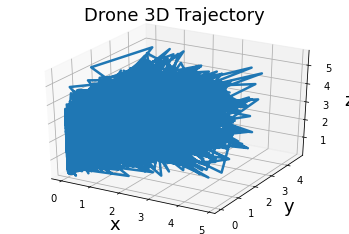

In [8]:
## Plot Trajectory
traj = envs.sim.collect_traj

import matplotlib.pyplot as plt

coords = [1, 3, 5, 9, 7, 11, 0, 2, 4, 8, 6, 10]
D = np.stack(traj, axis=0)
D_ = np.zeros_like(D)
for i in range(D.shape[1]):
    D_[:, i] = D[:, coords[i]]
  
xp = D[:, 1]
yp = D[:, 3]
zp = D[:, 5]
def plot3DTrajectory():
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    zline = zp
    xline = xp
    yline = yp
    ax.plot3D(xline, yline, zline, 'tab:blue', lw=2.5, label='Actual Drone Trajectory')
    plt.title('Drone 3D Trajectory', fontsize=18)
    ax.set_xlabel('x', fontsize=18)
    ax.set_ylabel('y', fontsize=18)
    ax.set_zlabel('z', fontsize=18)
    # plt.legend(fontsize=18)
    plt.show()
plot3DTrajectory()

In [9]:
import pickle
pickle_out=open('trajectory.pkl','wb') #path '/Users/constantinos/Google Drive/pickles-notebooks/feed_dict_11_multienv.pickle'
pickle.dump(D_,pickle_out)
pickle_out.close()
pickle_in = open('trajectory.pkl', 'rb')
my_trajectory = pickle.load(pickle_in)

In [ ]:
print(len(my_trajectory))
print(my_trajectory[-1])

1344000
[ 6.89517529e-01  1.86717119e+00  1.88638729e+00 -2.78122806e-04
  6.41030901e-04  3.31773092e-07 -2.81302008e-03 -6.48444721e-03
 -2.50677935e-01  2.71693374e-04 -6.25876932e-04 -3.37230511e-07]


In [25]:
device = torch.device('cpu') # override

my_traj = torch.from_numpy(my_trajectory).to(device)
x_star_ = torch.Tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).to(device)   # Goal [x,y,z,...]

skip = 100 #3000 # we skip 20 frams at a time
t = []
for i in range(int(my_traj.shape[0]/skip)):
    t.append(my_traj[i*skip,:][None])

my_trajs_reduced = np.concatenate(t)
my_t_span = torch.linspace(0, 2, my_trajs_reduced.shape[0]+1)

In [26]:
!pip install torchdyn -q
!pip install ptflops -q

In [27]:
%cd drive/MyDrive/DeepRL/Torch_Control
import sys; sys.path.append(2*'../') # go n dirs back
from torchcontrol.torchcontrol.systems.quadcopter import euler_matrix
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def cuboid_data2(pos, size=(1,1,1), rotation=None):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    if rotation is not None:
        for i in range(4):
            X[:,i,:] = np.dot(rotation, X[:,i,:].T).T
    X += pos
    return X

# Plot cube for drone body
def plot_cube(position,size=None,rotation=None,color=None, **kwargs):
    if not isinstance(color,(list,np.ndarray)): color=["C0"]*len(position)
    if not isinstance(size,(list,np.ndarray)): size=[(1,1,1)]*len(position)
    g = cuboid_data2(position, size=size, rotation=rotation)
    return Poly3DCollection(g,  
                            facecolor=np.repeat(color,6), **kwargs)

def my_animate_quadcopter_3d(traj, x_star, t_span, path='quadcopter_animation.gif', html_embed=False):
    '''
    Animate drone and save gif
    Args
        traj: drone trajectory
        x_star: target position
        t_span: time vector corresponding to each trajectory
        path: save path for 
        html_embed: embed mp4 video in the page
    '''

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')

    # For visualization
    scale = 1.5
    s = 50
    dxm = scale*0.16      # arm length (m)
    dym = scale*0.16      # arm length (m)
    dzm = scale*0.05      # motor height (m)
    s_drone = scale*10 # drone body dimension
    lw = scale
    drone_size = [dxm/2, dym/2, dzm]
    drone_color = ["royalblue"]

    lim = [0, x_star[2]*5] # was 1.2
    ax.set_xlim3d(lim[0], lim[1])
    ax.set_ylim3d(lim[0], lim[1])
    ax.set_zlim3d(lim[0], lim[1])
    ax.set_xlabel('x[m]')
    ax.set_ylabel('y[m]')
    ax.set_zlabel('z[m]')

    lines1, lines2 = [], []
    l1, = ax.plot([], [], [], lw=2, color='red')
    l2, = ax.plot([], [], [], lw=2, color='green')

    body, = ax.plot([], [], [], marker='o', markersize=s_drone, color='black', markerfacecolor='black')

    initial = traj[0]
    tr = traj

    # Single frame plotting
    def get_frame(i):
        del ax.collections[:] # remove previous 3D elements 
        init = ax.scatter(initial[0], initial[1], initial[2], marker='^', color='blue', label='Initial Position', s=s)
        fin = ax.scatter(x_star[0], x_star[1], x_star[2], marker='*', color='red', label='Target', s=s) # set linestyle to none
        ax.plot(tr[:i, 0], tr[:i, 1], tr[:i, 2],  alpha=0.1, linestyle='-.', color='tab:blue')
        time = t_span[i]
        pos = tr[i]
        x = pos[0]
        y = pos[1]
        z = pos[2]

        x_from0 = tr[0:i,0]
        y_from0 = tr[0:i,1]
        z_from0 = tr[0:i,2]

        # Trick to reuse the same function
        R = euler_matrix(torch.Tensor([pos[3]]), torch.Tensor([pos[4]]), torch.Tensor([pos[5]])).numpy().squeeze(0)
        motorPoints = np.array([[dxm, -dym, dzm], [0, 0, 0], [dxm, dym, dzm], [-dxm, dym, dzm], [0, 0, 0], [-dxm, -dym, dzm],  [-dxm, -dym, -dzm]])
        motorPoints = np.dot(R, np.transpose(motorPoints))
        motorPoints[0,:] += x 
        motorPoints[1,:] += y 
        motorPoints[2,:] += z

        # Motors
        l1.set_data(motorPoints[0,0:3], motorPoints[1,0:3])
        l1.set_3d_properties(motorPoints[2,0:3])
        l2.set_data(motorPoints[0,3:6], motorPoints[1,3:6])
        l2.set_3d_properties(motorPoints[2,3:6])

        # Body
        pos = ((motorPoints[:, 6] + 2*motorPoints[:, 1])/3)
        body = plot_cube(pos, drone_size, rotation=R, edgecolor="k")
        ax.add_collection3d(body)

        ax.set_title("Quadcopter Trajectory, t = {:.2f} s".format(time))
        
    # Unused for now
    def anim_callback(i, get_world_frame):
        frame = get_world_frame(i)
        set_frame(frame)
        
    # Frame setting
    def set_frame(frame):
        # convert 3x6 world_frame matrix into three line_data objects which is 3x2 (row:point index, column:x,y,z)
        lines_data = [frame[:,[0,2]], frame[:,[1,3]], frame[:,[4,5]]]
        ax = plt.gca()
        lines = ax.get_lines()
        for line, line_data in zip(lines[:3], lines_data):
            x, y, z = line_data
            line.set_data(x, y)
            line.set_3d_properties(z)
            
    an = FuncAnimation(fig,
                        get_frame,
                        init_func=None,
                        frames=len(t_span)-1, interval=20, blit=False)

    # an.save(path, dpi=80, writer='imagemagick', fps=20)

    if html_embed: HTML(an.to_html5_video())
    
    return an

[Errno 2] No such file or directory: 'drive/MyDrive/DeepRL/Torch_Control'
/content/drive/MyDrive/DeepRL/Torch_Control


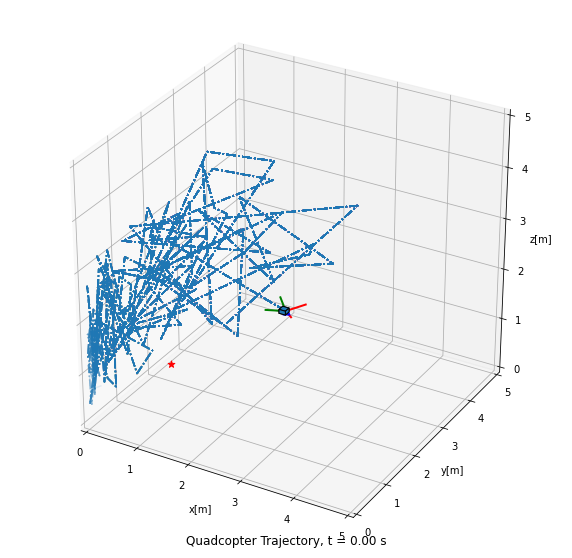

In [28]:
my_animated = my_animate_quadcopter_3d(my_trajs_reduced, x_star_, my_t_span, html_embed=True)

In [29]:
from matplotlib import rc
rc('animation', html='html5') # YOU NEED THIS ELSE IT WONT SHOW ANYTHING!!!

In [30]:
my_animated